# Imports básicos para todas as análises

In [3]:
# Desativar as mensagens de 'warning' que ficam poluindo o output aqui no Colab

import warnings
warnings.filterwarnings("ignore")

In [4]:
# Importações dos módulos necessários para autenticar na minha conta Google e acessar o Drive
import  pandas as pd,               \
        numpy as np,                \
        matplotlib.pyplot as plt,   \
        requests as rt,             \
        seaborn as sns,             \
        xml.etree.ElementTree as ET

from io               import BytesIO
from tqdm             import tqdm
from matplotlib.pylab import rcParams
from pandas.plotting  import register_matplotlib_converters

from sktime.utils.plotting import plot_series
from sktime.forecasting.compose import make_reduction
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError

# Ajustes feitos para geração e criação de gráfico
rcParams['figure.figsize'] = 15, 6

# Tratar conversões de DateTime entre o Pandas e o Matplotlib
register_matplotlib_converters()

### Funções úteis

In [3]:
# import calendar
# import datetime
# import json
# import os
# import requests
# import xml.etree.ElementTree as ET
# from tqdm import tqdm

# def get_data_telemetrica(codEstacao, dataInicio, dataFim): #, save=False

#     # 1. Fazer a requisião ao servidor e pegar a árvore e a raiz dos dados
#     params = {'codEstacao':codEstacao, 'dataInicio':dataInicio, 'dataFim':dataFim}
#     server = 'http://telemetriaws1.ana.gov.br/ServiceANA.asmx/DadosHidrometeorologicos'
#     response = requests.get(server, params)
#     tree = ET.ElementTree(ET.fromstring(response.content))
#     root = tree.getroot()

#     # 2. Iteração dentro dos elementos do XML procurando os dados que são disponibilizados para a estação
#     list_vazao = []
#     list_data = []
#     list_nivel = []
#     list_chuva = []

#     for i in tqdm(root.iter('DadosHidrometereologicos')):

#         data = i.find('DataHora').text
#         try:
#             vazao = float(i.find('Vazao').text)
#         except TypeError:
#             vazao = i.find('Vazao').text

#         try:
#             nivel = float(i.find('Nivel').text)
#         except TypeError:
#             nivel = i.find('Nivel').text

#         try:
#             chuva = float(i.find('Chuva').text)
#         except TypeError:
#             chuva = i.find('Chuva').text

#         list_vazao.append(vazao)
#         list_data.append(data)
#         list_nivel.append(nivel)
#         list_chuva.append(chuva)

#     df = pd.DataFrame([list_data, list_nivel, list_chuva, list_vazao]).transpose()
#     df.columns = ['Data', 'Nivel', 'Chuva', 'Vazao']

#     df = df.sort_values(by='Data')
#     df = df.set_index('Data')
#     df.index = pd.to_datetime(df.index)

#     # if save == True:
#     #     df.to_excel(codEstacao+'_dados.xlsx')

#     return df

In [35]:
def sliding_window(data, n_lags=1, n_targets=1, dropnan=True):
	"""
	Rearranja a série temporal como um dataset para aprendizado supervisionado.
	Argumentos:
		data: Sequência de observações. Pode ser list ou NumPy array
		n_lags: Número de lags das observações que serão usadas como input (X).
		n_targets: Número de observações que serão usadas como output (y).
		dropnan: Booleano pra dropar as linhas que ficarem com NaN .
	Retorna:
		Um DataFrame como uma série ajustada para aprendizado supervisionado.
	"""
	n_vars = 1 if type(data) is list else data.shape[1]

	df = pd.DataFrame(data)
	cols, names = list(), list()

	# As lags (t-n, ... t-1)
	for i in range(n_lags, 0, -1):
		cols.append(df.shift(i))
		names += [('X_%d(t-%d)' % (j+1, i)) for j in range(n_vars)]

	# Prever uma sequência (t, t+1, ... t+n)
	for i in range(0, n_targets):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('y_%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('y_%d(t+%d)' % (j+1, i)) for j in range(n_vars)]

	# Junta tudo
	agg = pd.concat(cols, axis=1)
	agg.columns = names

	# Dropa as linhas com NaN
	if dropnan:
		agg.dropna(inplace=True)

	return agg # IMPORTANTE!!!! O retorno sai com as colunas com nome zuado. Tem que renomear o DataFrame resultante depois.

In [34]:
# O corte realizado por esse método é simples: pega do início da série até train_size e coloca num dataframe para treino
# O que resta do corte anterior, é colocado no dataframe para teste
def split_train_test(df, train_size=0.7):

  # Tamanho total da série
  size = df.shape[0]

  # Tamanho do treino
  t_size = int(size * train_size)

  train_data = df.iloc[0:t_size]
  validation_data = df.iloc[t_size:]

  return train_data, validation_data

#### Ajustando as planilhas das estações CONVENCIONAIS

Deixando todas elas com a mesma 'cara' padrão, com um campo 'data' no formato 'yyyy-mm-dd'

In [1]:
# Primeiro listo os arquivos CSV
# Mais adiante separo os nomes das estações convencionais das telemétricas

import glob

p_baixo = "./estacoes_baixo/"
p_medio = "./estacoes_medio/"
csv_str = "*.csv"

fls_baixo = glob.glob(p_baixo+csv_str)
fls_medio = glob.glob(p_medio+csv_str)

fls_baixo, fls_medio

(['./estacoes_baixo/chuva_1640000.csv',
  './estacoes_baixo/cota_54780000.csv',
  './estacoes_baixo/telemetric_54790000.csv',
  './estacoes_baixo/vazao_54780000.csv'],
 ['./estacoes_medio/chuva_1642007.csv',
  './estacoes_medio/chuva_1642008.csv',
  './estacoes_medio/chuva_1642027.csv',
  './estacoes_medio/cota_54150000.csv',
  './estacoes_medio/cota_54193000.csv',
  './estacoes_medio/cota_54195000.csv',
  './estacoes_medio/telemetric_1642041.csv',
  './estacoes_medio/telemetric_54140000.csv',
  './estacoes_medio/telemetric_54150001.csv',
  './estacoes_medio/vazao_54140000.csv',
  './estacoes_medio/vazao_54150000.csv',
  './estacoes_medio/vazao_54193000.csv',
  './estacoes_medio/vazao_54195000.csv'])

In [ ]:
# Pego os nomes apenas das estações CONVENCIONAIS

csv_baixo = ['chuva_1640000.csv',
             'cota_54780000.csv',
             'vazao_54780000.csv']

p_ajust_baixo = p_baixo + "planilhas_ajustadas/" # Salvo os arquivos ajustados em outra pasta para não interferir com os arquivos baixados originais

for f in csv_baixo:

        # Carrega o arquivo
        df = pd.read_csv(p_baixo+f, sep='\t', header=0)

        # Renomeia as colunas 'ano', 'mes' e 'dia' para poder fazer o parse da data posteriormente
        df.rename(columns={'ano': 'year', 'mes': 'month', 'dia': 'day'}, inplace=True)

        # Criar uma coluna extra de datetime, combinando as 3 colunas
        df["data"] = pd.to_datetime(df[['year', 'month', 'day']])

        # Formatar a coluna de datetime como YYYY-mm-dd
        df["data"] = df["data"].dt.strftime("%Y-%m-%d")

        # Limpa o DataFrame
        df.drop(columns=['year', 'month', 'day'], inplace=True)

        df.set_index('data', inplace=True)

        # Salvar para o arquivo
        df.to_csv(p_ajust_baixo+f, sep='\t')

# =================================================================== #

csv_medio = ['chuva_1642007.csv',
             'chuva_1642008.csv',
             'chuva_1642027.csv',
             'cota_54150000.csv',
             'cota_54193000.csv',
             'cota_54195000.csv',
             'vazao_54140000.csv',
             'vazao_54150000.csv',
             'vazao_54193000.csv',
             'vazao_54195000.csv']

p_ajust_medio = p_medio + "planilhas_ajustadas/"

for f in csv_medio:

        # Carrega o arquivo
        df = pd.read_csv(p_medio+f, sep='\t', header=0)

        # Renomeia as colunas 'ano', 'mes' e 'dia' para poder fazer o parse da data posteriormente
        df.rename(columns={'ano': 'year', 'mes': 'month', 'dia': 'day'}, inplace=True)

        # Criar uma coluna extra de datetime, combinando as 3 colunas
        df["data"] = pd.to_datetime(df[['year', 'month', 'day']])

        # Formatar a coluna de datetime como YYYY-mm-dd
        df["data"] = df["data"].dt.strftime("%Y-%m-%d")

        # Limpa o DataFrame
        df.drop(columns=['year', 'month', 'day'], inplace=True)

        df.set_index('data', inplace=True)

        # Salvar para o arquivo
        df.to_csv(p_ajust_medio+f, sep='\t')

#### Ajustando as planilhas das estações TELEMÉTRICAS

Deixando todas elas com um campo 'data' no formato 'yyyy-mm-dd'.

Os dados telemétricos (que vieram num medição horária ou 15/15 minutos) já foram agregados para o padrão diário

-> chuva: foi agregado realizando o somatório do dia </br>
-> cota/nível e vazão: foi agregado calculando a média do dia

In [ ]:
# Ajuste apenas da estações TELEMÉTRICAS

csv_baixo = ['telemetric_54790000.csv']

p_ajust_baixo = p_baixo + "planilhas_ajustadas/"

for f in csv_baixo:

    df = pd.read_csv(p_baixo+f, sep='\t', index_col=0, header=0, parse_dates=['dataHora'])

    # Os campos numéricos são carregados como do tipo "object" e por isso precisam ser convertidos para "float"
    # "coerce" força onde não tiver número para converter colocar "NaN" no lugar
    df.chuva = pd.to_numeric(df.chuva, errors='coerce')
    df.nivel = pd.to_numeric(df.nivel, errors='coerce')
    df.vazao = pd.to_numeric(df.vazao, errors='coerce')

    df = df.resample('D').agg({'chuva': 'sum', 'nivel': 'mean', 'vazao': 'mean'})

    # Mesmo após fazer a agregação por dia, alguns ficam com "NaN", por isso a necessidade de executar o "fillna"
    df.fillna({'chuva': df['chuva'].sum(), 'nivel': df['nivel'].mean(), 'vazao': df['vazao'].mean()}, inplace=True)

    # Renomeia a coluna de índice 'dataHora' para padronizar com as estações convencionais
    df.index.name = "data"

    # Salvar para o arquivo
    df.to_csv(p_ajust_baixo+f, sep='\t')

# =================================================================== #
    
csv_medio = ['telemetric_1642041.csv',
             'telemetric_54140000.csv',
             'telemetric_54150001.csv']

p_ajust_medio = p_medio + "planilhas_ajustadas/"

for f in csv_medio:

    df = pd.read_csv(p_medio+f, sep='\t', index_col=0, header=0, parse_dates=['dataHora'])

    # Os campos numéricos são carregados como do tipo "object" e por isso precisam ser convertidos para "float"
    # "coerce" força onde não tiver número para converter colocar "NaN" no lugar
    df.chuva = pd.to_numeric(df.chuva, errors='coerce')
    df.nivel = pd.to_numeric(df.nivel, errors='coerce')
    df.vazao = pd.to_numeric(df.vazao, errors='coerce')

    df = df.resample('D').agg({'chuva': 'sum', 'nivel': 'mean', 'vazao': 'mean'})

    # Mesmo após fazer a agregação por dia, alguns ficam com "NaN", por isso a necessidade de executar o "fillna"
    df.fillna({'chuva': df['chuva'].sum(), 'nivel': df['nivel'].mean(), 'vazao': df['vazao'].mean()}, inplace=True)

    # Renomeia a coluna de índice 'dataHora' para padronizar com as estações convencionais
    df.index.name = "data"

    # Salvar para o arquivo
    df.to_csv(p_ajust_medio+f, sep='\t')

# Médio Jequitinhonha

#### Gerando a planilha com os dados do MÉDIO Jequitinhonha

In [ ]:
# Série Temporal com os dados endógenos (variável alvo 'y')
st_endogena = "./estacoes_medio/planilhas_ajustadas/principal_vazao_54195000.csv"
df_left = pd.read_csv(st_endogena, sep='\t', index_col=0, header=0, parse_dates=['data'])

# Séries Temporais com os dados exógenos (as outras informações que usarei para aprimorar o treinamento da rede)
st_exogena = ["./estacoes_medio/planilhas_ajustadas/chuva_1642007.csv",
              "./estacoes_medio/planilhas_ajustadas/chuva_1642008.csv",
              "./estacoes_medio/planilhas_ajustadas/chuva_1642027.csv",
              "./estacoes_medio/planilhas_ajustadas/cota_54150000.csv",
              "./estacoes_medio/planilhas_ajustadas/cota_54193000.csv",
              "./estacoes_medio/planilhas_ajustadas/cota_54195000.csv",
              "./estacoes_medio/planilhas_ajustadas/telemetric_1642041.csv",
              "./estacoes_medio/planilhas_ajustadas/telemetric_54140000.csv",
              "./estacoes_medio/planilhas_ajustadas/telemetric_54150001.csv",
              "./estacoes_medio/planilhas_ajustadas/vazao_54140000.csv",
              "./estacoes_medio/planilhas_ajustadas/vazao_54150000.csv",
              "./estacoes_medio/planilhas_ajustadas/vazao_54193000.csv"]

df_list = []
for f in st_exogena:
    df_list.append(pd.read_csv(f, sep='\t', index_col=0, header=0, parse_dates=['data']))
  
for df in df_list:
    df_result = df_left.merge(df, how='left', on='data', suffixes=(None, '_r'))
    df_left = df_result

# Tem que alterar os nomes das colunas para algo compreensível
# Vejo como ficaram os nomes das colunas depois do merge
# print('Nomes das colunas depois do merge...:\n%s\n' % str(df_left.columns.values))

# Eu já sei que a primeira coluna chamada 'y' corresponde à estação principal a ser analisada para o trecho da bacia em questão
# Deixo desta forma pois o NeuralForecast demanda que a coluna alvo (target) tenha o nome 'y'
# As demais colunas comporão o que chamam de 'variáveis exógenas' da série temporal
novas_colunas = ['y', 'chuva1', 'chuva2', 'chuva3', 'cota1', 'cota2', 'cota3',
                 'chuva4', 'chuva5', 'cota4', 'vazao1', 'chuva6', 'cota5',
                 'vazao2', 'vazao3', 'vazao4', 'vazao5']

df_left.columns = novas_colunas
# print('Colunas ajustadas...:\n%s\n' % str(df_left.columns.values))

# A coluna index, neste caso, 'data' precisa ter o nome 'ds'
# Novamente, o NeuralForecast demanda que a coluna contendo as datas tenha este nome
df_left.index.name = 'ds'

# Confere se ficou tudo conforme o desejado
# df_left

# Estando tudo ajustado, de acordo com o padrão deseja, salva para uma planilha externa
df_left.to_csv('medio_jequitinhonha.csv', sep='\t')

#### Carregando os dados para análise

In [38]:
df_medio_jeq = pd.read_csv('medio_jequitinhonha.csv', sep='\t', index_col=0, header=0, parse_dates=['ds'])
df_medio_jeq = df_medio_jeq.resample('D').first() # deixando a série contínua numa base diária
df_medio_jeq.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3683 entries, 2013-01-01 to 2023-01-31
Freq: D
Data columns (total 17 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   y       3673 non-null   float64
 1   chuva1  3683 non-null   float64
 2   chuva2  3682 non-null   float64
 3   chuva3  3653 non-null   float64
 4   cota1   3683 non-null   float64
 5   cota2   3262 non-null   float64
 6   cota3   3349 non-null   float64
 7   chuva4  54 non-null     float64
 8   chuva5  2819 non-null   float64
 9   cota4   2819 non-null   float64
 10  vazao1  2819 non-null   float64
 11  chuva6  2810 non-null   float64
 12  cota5   2810 non-null   float64
 13  vazao2  2810 non-null   float64
 14  vazao3  210 non-null    float64
 15  vazao4  3683 non-null   float64
 16  vazao5  2542 non-null   float64
dtypes: float64(17)
memory usage: 517.9 KB


In [39]:
# Ajustando os valores NaN do DataFrame

df_medio_jeq.fillna({'y' : df_medio_jeq['y'].mean(),
                     'chuva1' : df_medio_jeq['chuva1'].mean(),
                     'chuva2' : df_medio_jeq['chuva2'].mean(),
                     'chuva3' : df_medio_jeq['chuva3'].mean(),
                     'chuva4' : df_medio_jeq['chuva4'].mean(),
                     'chuva5' : df_medio_jeq['chuva5'].mean(),
                     'chuva6' : df_medio_jeq['chuva6'].mean(),
                     'cota1' : df_medio_jeq['cota1'].mean(),
                     'cota2' : df_medio_jeq['cota2'].mean(),
                     'cota3' : df_medio_jeq['cota3'].mean(),
                     'cota4' : df_medio_jeq['cota4'].mean(),
                     'cota5' : df_medio_jeq['cota5'].mean(),
                     'vazao1' : df_medio_jeq['vazao1'].mean(),
                     'vazao2' : df_medio_jeq['vazao2'].mean(),
                     'vazao3' : df_medio_jeq['vazao3'].mean(),
                     'vazao4' : df_medio_jeq['vazao4'].mean(),
                     'vazao5' : df_medio_jeq['vazao5'].mean()}, inplace=True)

df_medio_jeq.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3683 entries, 2013-01-01 to 2023-01-31
Freq: D
Data columns (total 17 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   y       3683 non-null   float64
 1   chuva1  3683 non-null   float64
 2   chuva2  3683 non-null   float64
 3   chuva3  3683 non-null   float64
 4   cota1   3683 non-null   float64
 5   cota2   3683 non-null   float64
 6   cota3   3683 non-null   float64
 7   chuva4  3683 non-null   float64
 8   chuva5  3683 non-null   float64
 9   cota4   3683 non-null   float64
 10  vazao1  3683 non-null   float64
 11  chuva6  3683 non-null   float64
 12  cota5   3683 non-null   float64
 13  vazao2  3683 non-null   float64
 14  vazao3  3683 non-null   float64
 15  vazao4  3683 non-null   float64
 16  vazao5  3683 non-null   float64
dtypes: float64(17)
memory usage: 517.9 KB


In [40]:
# Separando em TREINO e VALIDAÇÃO
df_medio_treino, df_medio_valid = split_train_test(df_medio_jeq, 0.8)

df_medio_treino.info(), df_medio_valid.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2946 entries, 2013-01-01 to 2021-01-24
Freq: D
Data columns (total 17 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   y       2946 non-null   float64
 1   chuva1  2946 non-null   float64
 2   chuva2  2946 non-null   float64
 3   chuva3  2946 non-null   float64
 4   cota1   2946 non-null   float64
 5   cota2   2946 non-null   float64
 6   cota3   2946 non-null   float64
 7   chuva4  2946 non-null   float64
 8   chuva5  2946 non-null   float64
 9   cota4   2946 non-null   float64
 10  vazao1  2946 non-null   float64
 11  chuva6  2946 non-null   float64
 12  cota5   2946 non-null   float64
 13  vazao2  2946 non-null   float64
 14  vazao3  2946 non-null   float64
 15  vazao4  2946 non-null   float64
 16  vazao5  2946 non-null   float64
dtypes: float64(17)
memory usage: 414.3 KB
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 737 entries, 2021-01-25 to 2023-01-31
Freq: D
Data columns (total 17

(None, None)

#### Análise exploratória dos dados

<Axes: xlabel='ds'>

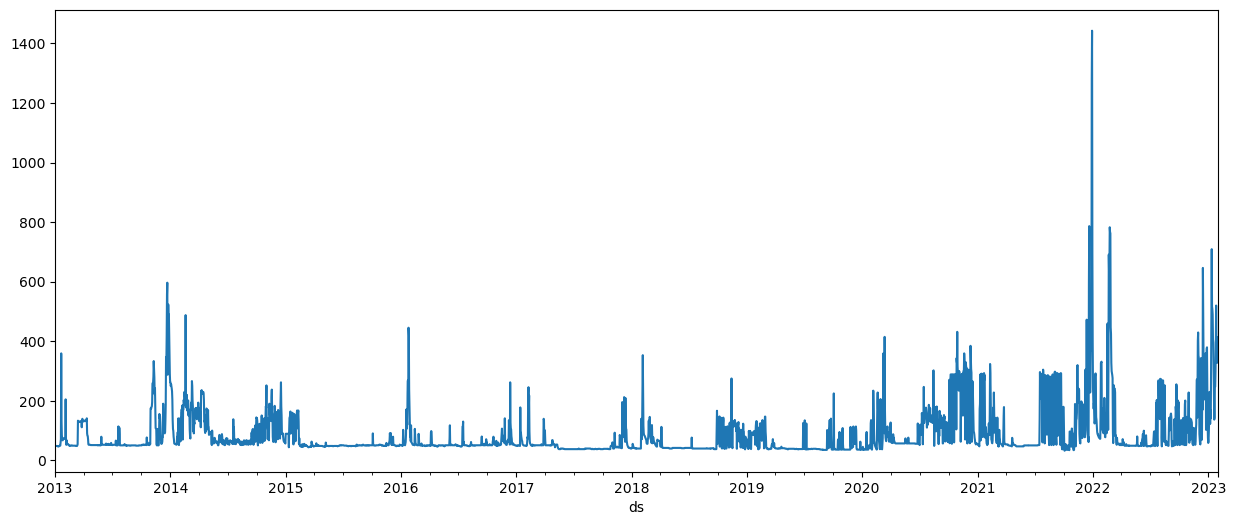

In [43]:
df_medio_jeq['y'].plot()

# Baixo Jequitinhonha